In [18]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score, mean_squared_error, mean_absolute_error,roc_auc_score,roc_curve
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

In [19]:
tweetsTest = pd.read_excel(r'C:/Users/Acer/Desktop/Text violation detection/Dataset/cartoonConvoTesting.xlsx',index_col=0)
tweetsTrain = pd.read_excel(r'C:/Users/Acer/Desktop/Text violation detection/Dataset/cartoonConvoTraining.xlsx',index_col=0)

In [20]:
tweetsTrain.head()

,Phrase,IsHateSpeech,Sentiment
PhraseNo,,,
1,"Yes, you! Baboon, baboon, baboon, baboon!",YES,1
2,"Did you hear that, Marge? She called me a babo...",YES,1
3,Nuts.,YES,1
4,Mmm... hors doovers.,YES,1
5,You stink! You and your whole lousy operation ...,YES,1


In [21]:
tweetsTest.head()

,Phrase,Sentiment
Phrase No,,
1,"Dad, why is everyone letting old people do thi...",0
2,"They've tried to stop them, son, but... the se...",0
3,They're saying something about taking over the...,0
4,"Yes. And now seeing how early they get up, I d...",0
5,"No. Come on, Dad. Can't you guys do it?\n",1


In [22]:
def form_sentence(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+', '', str(tweet))
    tweet = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", '', str(tweet))
    tweet = re.sub(r'<[^>]+>', '', str(tweet))
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', str(tweet))
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

In [23]:
def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

In [24]:
def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

In [25]:
Final_words = []
for data in tweetsTrain['Phrase']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_words.append(word_Final)


In [26]:
final_bodyTrain = pd.DataFrame(Final_words, columns=['Phrase'])


In [27]:
Final_wordss = []
for data in tweetsTest['Phrase']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_wordss.append(word_Final)

In [28]:
final_bodyTest = pd.DataFrame(Final_wordss, columns=['Phrase'])

In [29]:
tf = TfidfVectorizer()
tf.fit(final_bodyTrain['Phrase'])

TfidfVectorizer()

In [30]:
Train_X_Tfidf = tf.transform(final_bodyTrain['Phrase'])
Test_X_Tfidf = tf.transform(final_bodyTest['Phrase'])

In [31]:
model = svm.SVC(kernel='linear')
model.fit(Train_X_Tfidf, tweetsTrain['Sentiment'])
predictions_SVM = model.predict(Test_X_Tfidf)


In [32]:
f1 = f1_score(predictions_SVM, tweetsTest['Sentiment'])
recall = recall_score(predictions_SVM, tweetsTest['Sentiment'])
precision = precision_score(predictions_SVM, tweetsTest['Sentiment'])
mse = mean_squared_error(predictions_SVM, tweetsTest['Sentiment'])
mae = mean_absolute_error(predictions_SVM, tweetsTest['Sentiment'])
auc = roc_auc_score(predictions_SVM, tweetsTest['Sentiment'])

Accuracy:  85.0
f1: 0.15238095238095237
recall: 0.25
precision: 0.1095890410958904
mse: 0.15
mae: 0.15
auc: 0.5671021377672208


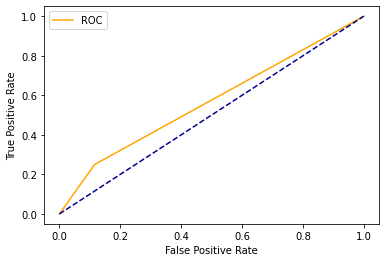

In [33]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

print("Accuracy: ", accuracy_score(predictions_SVM, tweetsTest['Sentiment']) * 100)
print('f1: ' + str(f1))
print('recall: ' + str(recall))
print('precision: ' + str(precision))
print('mse: ' + str(mse))
print('mae: ' + str(mae))
print('auc: ' + str(auc))

fpr, tpr, thresholds = roc_curve(predictions_SVM, tweetsTest['Sentiment'])
plot_roc_curve(fpr, tpr)

In [34]:
# STEP -7: Use the ML Algorithms to Predict the outcome
print("********* Naive bayes *********")
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, tweetsTrain['Sentiment'])
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, tweetsTest['Sentiment']) * 100)


********* Naive bayes *********
Naive Bayes Accuracy Score ->  82.97752808988764


In [35]:
import time
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score,roc_auc_score,roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tqdm import tqdm

In [36]:
# prepare tokenizer
token = Tokenizer()
token.fit_on_texts(final_bodyTrain['Phrase'])

In [37]:
# integer encode the documents
seq = token.texts_to_sequences(final_bodyTrain['Phrase'])

In [38]:
# pad documents to a max length of words
max_length = 100
pad_seq = pad_sequences(seq,maxlen=max_length, padding='post')

In [39]:
# test set
x_test = final_bodyTest['Phrase']
x_test = token.texts_to_sequences(x_test)
testing_seq = pad_sequences(x_test,maxlen=max_length, padding='post')

In [40]:
vocab_size = len(token.word_index)+1

In [41]:
# load the whole embedding into memory
embedding_vector = {}
f = open('C:/Users/Acer/Desktop/Text violation detection/glove.6B.100d.txt', encoding='utf-8')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef
f.close()


400000it [00:28, 14057.81it/s]


In [42]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 2820/2820 [00:00<00:00, 202512.37it/s]


In [43]:
# define the keras model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights = [embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(100, dropout=0.5)))
model.add(Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))


In [44]:
# get each epoch time
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [45]:
# compile the keras model
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics = ['accuracy','mse','mae'])

time_callback = TimeHistory()
history = model.fit(pad_seq, tweetsTrain['Sentiment'], epochs=2, batch_size=32, validation_data= (testing_seq, tweetsTest['Sentiment']) ,callbacks=[time_callback])
yhat_probs = model.predict(testing_seq, verbose=0)
yhat_classes = model.predict_classes(testing_seq, verbose=0)
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

loss, accuracy, mse, mae = model.evaluate(testing_seq, tweetsTest['Sentiment'])
f1 = f1_score(tweetsTest['Sentiment'], yhat_classes)
recall = recall_score(tweetsTest['Sentiment'], yhat_classes)
precision = precision_score(tweetsTest['Sentiment'], yhat_classes)
auc = roc_auc_score(tweetsTest['Sentiment'], yhat_probs)

Train on 2000 samples, validate on 1780 samples
Epoch 1/2
2000/2000 [==============================] - 22s 11ms/sample - loss: 0.8450 - accuracy: 0.5770 - mse: 0.2476 - mae: 0.4953 - val_loss: 0.7892 - val_accuracy: 0.8702 - val_mse: 0.2208 - val_mae: 0.4688
Epoch 2/2
1780/1780 [==============================] - 3s 2ms/sample - loss: 0.7423 - accuracy: 0.8753 - mse: 0.1996 - mae: 0.4433


In [46]:
print(model.summary())
# save model and architecture to single file
# model.save("binary_LSTM.h5")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          282100    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 8)                 1608      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 444,517
Trainable params: 162,417
Non-trainable params: 282,100
_________________________________________________________________
None


In [47]:
count = 0
for val in time_callback.times:
    count +=val

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Accuracy: 87.52809166908264
loss: 0.7422887135087775
mse: 0.19959031
mae: 0.44332814
f1: 0.0
recall: 0.0
precision: 0.0
auc: 0.4858465039680102
Total train time: 35.145029067993164


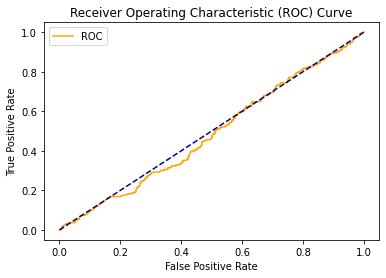

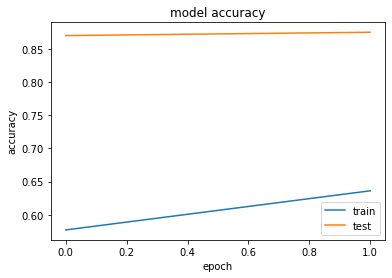

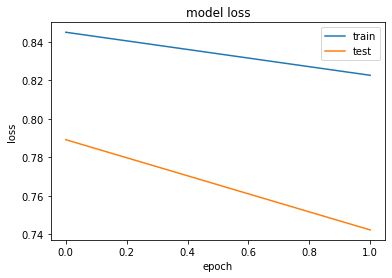

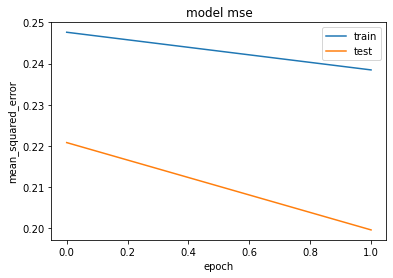

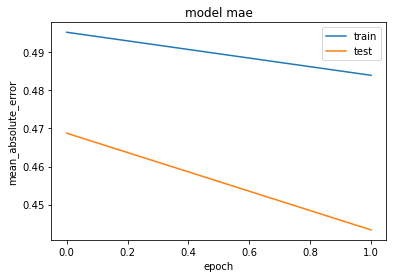

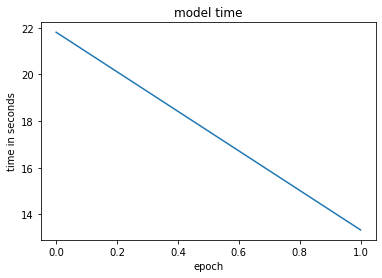

[0.8702247, 0.8752809]
[0.7891604809278853, 0.7422887135087775]
[0.22080079, 0.19959031]
[0.46875355, 0.44332814]


In [48]:
print('Accuracy: ' + str(accuracy*100))
print('loss: ' + str(loss))
print('mse: ' + str(mse))
print('mae: ' + str(mae))
print('f1: ' + str(f1))
print('recall: ' + str(recall))
print('precision: ' + str(precision))
print('auc: ' + str(auc))
print('Total train time: '+ str(count))

fpr, tpr, thresholds = roc_curve(tweetsTest['Sentiment'], yhat_probs)
plot_roc_curve(fpr, tpr)
          
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for mse
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for time
plt.plot(time_callback.times)
plt.title('model time')
plt.ylabel('time in seconds')
plt.xlabel('epoch')
plt.show()

print(history.history['val_accuracy'])
print(history.history['val_loss'])
print(history.history['val_mse'])
print(history.history['val_mae'])